# Qiskit Fall Fest 2023

![QFF Logo](images/QFF-logo.png)

## Challenge 5: Dynamic Circuits in Qiskit

## Part 1: Intro To Dynamic Circuits

Qiskit 교육자료인 [Qiskit textbook](https://learn.qiskit.org/course/ch-algorithms/quantum-circuits)에는 다음과 같은 말이 있습니다.
>_"A quantum circuit is a computational routine consisting of coherent quantum operations on qubits ... It is an ordered sequence of quantum gates, measurements and resets, all of which may be conditioned on and use data from the real-time classical computation."_

위 문구를 한국말로 직해하면 다음과 같습니다.
>_양자 회로는 qubit에 대한 일관성 있는 양자 연산으로 구성된 계산 루틴입니다 ... 양자 gate, 측정 및 리셋의 순서대로 나열되는 것이며, 이 모든 것은 실시간 고전 컴퓨팅 계산의 데이터에 따라 조건화되어 사용될 수 있습니다._

인용구의 마지막 문장이 잘 이해가 되지 않으실 수 있습니다. 하지만 그 문장이 dynamic circuit과 직접적으로 연관된 내용입니다. 별다른 수식어 없이 양자 회로라고 말하면 보통 _static_ 양자 회로를 의미합니다. 이전 챌린지에서 봤던 것들은 전부 static 양자 회로입니다. 그러다면 dynamic circuits은 무엇일까요?

지금까지 여러분이 챌린지에서 봐왔던 양자 회로들은 전부 $|0\rangle$ 상태에서 시작하여, 양자 gate들을 가하고, 마지막에 측정을 하는 방식이었습니다. 반면에 **Dynamic circuits**은 양자 회로 중간에 측정을 하여, 그 측정 결과를 바탕으로 후반부 양자 gate 를 어떻게 가할지 결정하는 양자 회로입니다. 이러한 측정 결과는 당연하게도 중첩 같은 성질이 없는 고전적인 값이며, 이러한 고전적인 측정 결과에 따라 이후의 양자 연산을 조건화하는 것을 _classical feedforward_ 라고 합니다.

왜 classical feedforward가 필요할까요? 이러한 feedforward가 필요한 대표적인 예시는 conditional reset이라고 불리는 과정이며 Qiskit에서는 [`reset`](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.reset.html) 연산이 이에 해당 합니다. reset은 non-unitary 연산자로서 이전의 양자 상태가 무슨 상태인지 상관없이 reset 연산을 거치면 그 qubit의 양자 상태는 $|0\rangle$ 상태가 됩니다. 이 reset 연산은 다음과 같은 과정을 통해 이루어집니다. 해당 qubit을 측정한 후에, 측정 결과가 $|0\rangle$이면 아무런 행동을 취하지 않고, 측정 결과가 $|1\rangle$ 이라면 X gate를 가해서 $|0\rangle$ 상태로 만듭니다. 즉, 해당 qubit를 측정하여 $|0\rangle$ 혹은 $|1\rangle$ 상태로 붕괴(collapse)시키고, 만약 $|1\rangle$라면 X gate를 가해 $|0\rangle$로 만들어 주는 것입니다.

이러한 conditional reset 연산을 보시면 qubit 측정 후에 측정 결과를 기반으로 X gate를 가할지 말지 결정하기에 해당 연산이 들어간 회로는 dynamic circuit 이라고 할 수 있습니다.

<center>
<img src="images/sketch-1.png" width="50%">
</center>

동적 회로는 'if'문 및 'while' 루프와 같은 제어 흐름을 포함하는 양자 회로로 볼수 도 있습니다.

### Hello Dynamic Circuit World

IBM Quantum의 실제 양자컴퓨터에서는 이미 한동안 회로 중간 측정 및 리셋을 지원하였지만, 그 측정 결과를 이용하여 이후의 양자 gate를 어떻게 가할지 결정하는 classical feedforward 기능은 2022년에야 도입되었습니다. Classical feedforward 기능을 지원하기 위해서는 제어 시스템 및 관련 소프트웨어를 대폭 재설계해야 했기 때문입니다.

Qiskit에서 dynamic circuit을 지원하기 위한 프로그래밍 문법은 계속해서 수정되어가고 있고 qiskit을 통해서는 해당 기능을 완전히 이용할 수는 없습니다. 현재(2023년 9월 기준) dynamic circuit의 완전한 기능에 접근할 수 있는 유일한 방법은 OpenQASM 3 언어로 프로그래밍을 작성하는 것입니다. 이번 챌린지에서는 Qiskit으로도 구현 가능한 범위만 다룰 예정입니다!

가장 처음 Qiskit에 도입되었던 classical feedforward 기능을 구현하는 명령어는 `c_if()` 명령입니다. 하지만 이 명령어 보다는 요즘에는 `if_test()` 매서드를 많이 사용합니다. 그리고 본 챌린지에서는 주로 `if_test()`를 사용하고자 합니다.

먼저 앞에서 dynamic circuit의 예시로 보여드렸던 conditional reset을 `if_test()`매서드를 이용하여 구현하는 것을 예제로 보여드리겠습니다. 다음의 과정을 통해 양자 회로를 만들어 나갈 것입니다.

1. 1개의 qubit과 2개의 classical bits를 가진 양자 회로를 만듭니다. (1개의 qubit과 2개의 classical bits의 이름은 `q0`, `b0`, 그리고 `b1`으로 합니다)
2. `q0`에 hadamard gate를 가합니다.
3. `q0`를 측정하고 그 결과를 `b0`에 저장합니다.
4. `if_test` 명령어를 이용하여 `b0` == 1 인지 확인합니다.
5. 만약 `b0` == 1 이라면 `q0`에 X gate를 가하여 $|0\rangle$로 만들어 줍니다.
6. `q0`를 측정하고 그 결과를 `b1`에 저장하고 그 값을 체크하여 항상 0이 나오는지 확인합니다.

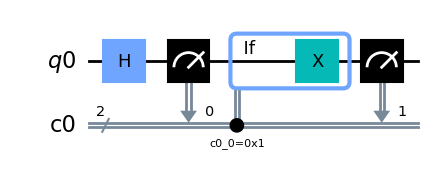

In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit import QuantumRegister, ClassicalRegister
from qiskit import qasm3

qr = QuantumRegister(1)
cr = ClassicalRegister(2)
qc = QuantumCircuit(qr, cr)

# unpack the qubit and classical bits from the registers
(q0,) = qr
b0, b1 = cr

# apply Hadamard
qc.h(q0)
# measure
qc.measure(q0, b0)

# begin if test block. the contents of the block are executed if b0 == 1
with qc.if_test((b0, 1)):
    # if the condition is satisfied (b0 == 1), then flip the bit back to 0
    qc.x(q0)
# finally, measure q0 again
qc.measure(q0, b1)

qc.draw(output="mpl", idle_wires=False)

양자 회로를 만들었으니 이 회로를 여러번 실행시키겠습니다. 첫번째 측정은 0 또는 1이 각각 절반의 확률로 나오겠지만 두번째 측정은 항상 0이 나오는 것을 확인하시길 바랍니다.

In [2]:
from qiskit_aer import AerSimulator

# initialize the simulator
backend_sim = AerSimulator()

# run the circuit
reset_sim_job = backend_sim.run(qc)
# get the results
reset_sim_result = reset_sim_job.result()
# retrieve the bitstring counts
reset_sim_counts = reset_sim_result.get_counts()

print(f"Counts: {reset_sim_counts}")

Counts: {'00': 504, '01': 520}


예상한 바와 같이 첫번째 측정 결과는 0 또는 1 모두 나올 수 있지만, 두번째 측정 결과는 0만 나옵니다. qiskit은 little-endian ordering을 사용한다는 것을 잊지 말기 바랍니다. 문자열 오른쪽이 첫번째 bit(`b0`)이고, 문자열 왼쪽이 두번째 bit(`b1`)입니다.

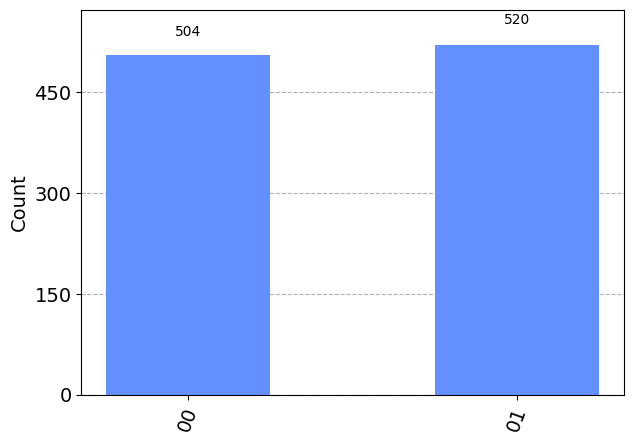

In [3]:
from qiskit.visualization import *

# plot histogram
plot_histogram(reset_sim_counts)

위에서는 측정 값이 특정한 조건을 만족할 때, 특정 행동을 하는 회로를 만들었습니다. 그럼 특정 조건을 만족하지 않을 때 어떠한 연산을 가하기 위해서는 어떻게 해야할까요? 파이썬에서 if와 함께 자주 나오는 else문이 생각나시나요? 이와 같은 개념이 dynamic circuit에도 존재합니다. 아래와 같이 코딩하면 됩니다.

In [4]:
with qc.if_test(조건) as else_:
    # 조건 만족할 때 수행할 작업
    
with else_:
    # 조건 불만족 시 수행할 작업

IndentationError: expected an indented block after 'with' statement on line 1 (3587900472.py, line 4)

자세한 예시는 아래에 있습니다.

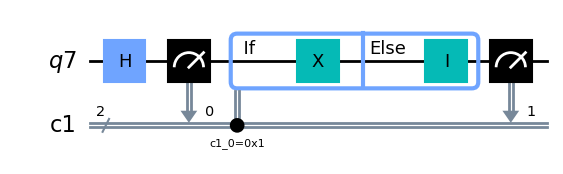

In [5]:
from qiskit import QuantumCircuit
from qiskit.circuit import QuantumRegister, ClassicalRegister

qr = QuantumRegister(1)
cr = ClassicalRegister(2)
qc = QuantumCircuit(qr, cr)

# unpack the qubit and classical bits from the registers
(q0,) = qr
b0, b1 = cr

# apply Hadamard
qc.h(q0)
# measure
qc.measure(q0, b0)

# begin if test block. the contents of the block are executed if b0 == 1
with qc.if_test((b0, 1)) as else_:
    # if the condition is satisfied (b0 == 1), then flip the bit back to 0
    qc.x(q0)


with else_:
    # if the condition is satisfied (b0 != 1), then apply identity operator to 0
    qc.i(q0)
# finally, measure q0 again
qc.measure(q0, b1)

qc.draw(output="mpl", idle_wires=False)

이제 여러분의 dynamic circuit을 만들어 가봅시다!

### 문제 1

앞의 예시보다는 조금 복잡한 것을 만들고자 합니다. 2 qubits와 2 classical bits를 가진 양자 회로를 만들고 `q0`의 관측 결과에 따라 `q1`에 가하는 gate를 다르게 할 것입니다. 여러분이 만드셔야 하는 회로에 대한 자세한 설명을 드리겠습니다.

만약 `q0` 관측 결과가 0 이라면 $X$ gate를 `q1`에 가하고, `q0` 관측 결과가 1 이라면 Hadamard gate를 `q1`에 가합니다.

`q0` 관측 결과에 무작위성을 부여하기 위하여 `q0`에 Hadamard gate를 먼저 가합니다. 그 후, `q0`의 관측 결과를 `b0`에 저장할 것입니다. 그 후 윗 문단에서 말한 _dynamic_ 조건에 기반하여 `q1`에 gate를 가하고 `q1`을 측정한 결과를 `b1`에 저장할 것입니다.

만약, `if_test()` 문을 작성하는 것에 어려움이 있으시다면 [링크](https://docs.quantum-computing.ibm.com/api/qiskit/qiskit.circuit.QuantumCircuit#if_test-1)를 클릭하여 `if_test()` documentation을 참고하시길 바랍니다.

**단, `if_test()` 문은 한 번만 사용하셔야 합니다.**

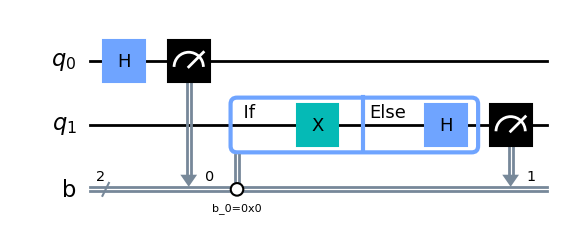

In [6]:
qr = QuantumRegister(2, name = "q")
cr = ClassicalRegister(2, name = "b")
qc = QuantumCircuit(qr, cr)

q0, q1 = qr
b0, b1 = cr

qc.h(q0)
qc.measure(q0, b0)


## Write your code below this line ## 

with qc.if_test((b0, 0)) as else_:
    qc.x(q1)
with else_:
    qc.h(q1)

## Do not change the code below this line ##


qc.measure(q1, b1)
qc.draw(output="mpl", idle_wires=False)

아래에서 여러분이 만든 회로가 잘 작동하는지 확인할 수 있습니다.

어떠한 결과가 나와야 하는지 미리 생각해보고 아래의 코드 셀을 실행시키시길 바랍니다.

In [7]:
backend_sim = AerSimulator()

job_1 = backend_sim.run(qc)
result_1 = job_1.result()
counts_1 = result_1.get_counts()

print(f"Counts: {counts_1}")

Counts: {'10': 539, '01': 238, '11': 247}


In [8]:
# Grader Cell: Run this to submit your answer

from qff_ku_grader.challenges.qff_ku2023 import grade_challenge5a

grade_challenge5a(qc)


Congratulations 🎉! Your answer is correct.


## Part 2: Repeat Until Success

양자 상태 측정 결과는 확률적으로 나오기 때문에 여러분이 원하는 결과가 나오지도 않을 때가 있습니다. 여러분이 만들고자 하는 알고리즘에 따라 중간에 측정을 했을 때 특정한 결과가 나와야지만 그 후에 연산을 해서 원하는 결과를 도출할 수 있는 경우도 있습니다. 대표적인 예시로는 HHL 알고리즘이 있습니다.

만약 여러분이 원하지 않은 결과과 중간 측정 때 나오면 어떻게 하실 것인가요? 음.. 다시 시도하면 됩니다! 여러분이 원하는 결과가 나올 확률이 0만 아니라면, 해당 과정을 계속 반복하다보면 결국 여러분이 원하는 결과가 나오게 될 것입니다.

보톧은 많은 반복을 하지 않아도 원하는 결과가 잘 나옵니다(이렇게 되도록 알고리즘을 만드는 것이 좋을 것입니다).

이번 파트에서는 "성공할 때까지 반복하기" 방법을 사용하여 $R_X(\theta)$ gate(이것이 무엇인지는 뒤에서 설명드리겠습니다)를 만들 것입니다. 여기서 여러분이 사용할 수 있는 gate들은 $\{H,\,X,\,S,\,\text{Toffoli}\}$ 이고, $\theta / \pi$가 무리수인 경우의 $R_X(\theta)$ gate를 구현해야합니다. 특히 여러분은 $\cos\theta = \frac35$에 해당하는 $\theta$ 만큼의 회전을 구현하시면 됩니다. 이것은 양자컴퓨팅 관련 대표 교재라고 할 수 있는 Nielsen and Chuang의 _Quantum Computation and Quantum Information_, 10<sup>th</sup> anniversary edition, Exercise 4.41 에서 다루는 universality of the finite gate set 내용과 관련되어 있다는 것을 말씀드립니다.

이것을 구현하기 위해서는 먼저 3개의 qubits가 필요합니다. 하나의 qubit은 "target" qubit이라고 부를 것이며, $R_X(\theta)$ gate가 가해지게 될 qubit 입니다. 다른 두개의 qubits는 "syndrome" qubit 이라고 부르며 이것을 측정하여 target qubit에 원하는 연산이 가해졌는지 여부를 판단하게 될 것입니다. 아래에서 여러분이 만들게 되는 회로에서는 만약 syndrome qubits를 측정했을 때 둘 다 $|0\rangle$상태로 측정이 된다면, target qubit에 원하는 연산이 가해진 것이고, 그렇지 않다면 qubits를 전부 reset 하고 다시 시작해야할 것입니다.

그럼 $R_X(\theta)$ gate 는 무엇일까요? 먼저 $R_X(\theta)$ gate의 수식을 보겠습니다.

$$R_X(\theta) = exp(-i\frac{\theta}{2}X) = \begin{bmatrix}\cos(\frac{\theta}{2})&-i\sin(\frac{\theta}{2})\\-i\sin(\frac{\theta}{2})&\cos(\frac{\theta}{2})\\ \end{bmatrix}$$

이와 같은 single qubit 연산입니다. 이것이 의미하는 것은 bloch sphere 상에서 양자 상태를 X축을 중심으로 $\theta$만큼 회전시키는 연산입니다. 아래에서 그 예시를 보겠습니다.

초기 상태


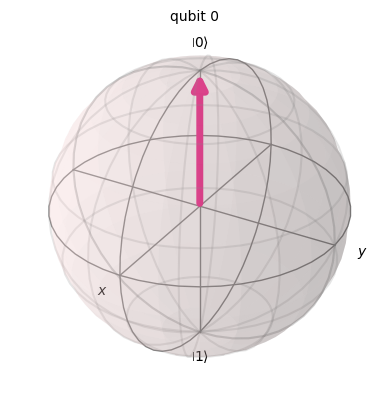


 X축을 기준으로 양의 방향으로 30도 회전


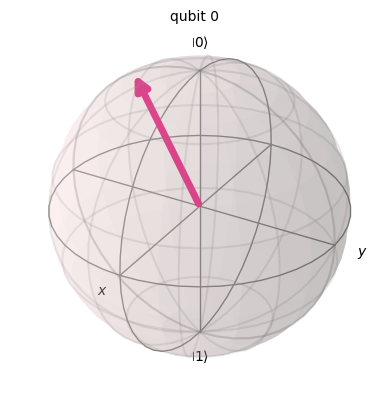


 X축을 기준으로 음의 방향으로 30도 회전


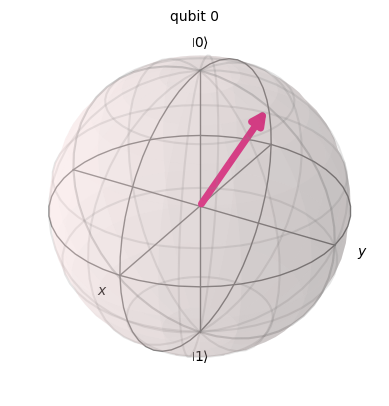


 X축을 기준으로 양의 방향으로 90도 회전


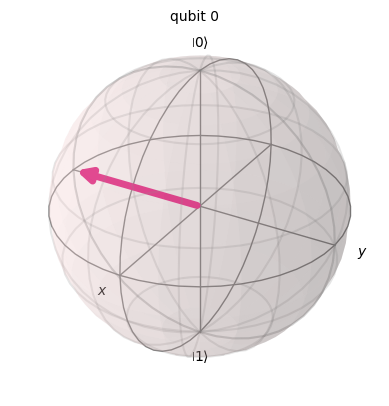

In [9]:
# 이 코드 셀을 실행시켜 주세요.
from qiskit.visualization import plot_bloch_multivector
import numpy as np

qc = QuantumCircuit(1)
print("초기 상태")
display(plot_bloch_multivector(qc))

print("\n X축을 기준으로 양의 방향으로 30도 회전") #30도는 radian으로 π/6
qc = QuantumCircuit(1)
qc.rx(np.pi/6, 0)
display(plot_bloch_multivector(qc))

print("\n X축을 기준으로 음의 방향으로 30도 회전") #30도는 radian으로 π/6
qc = QuantumCircuit(1)
qc.rx(-np.pi/6, 0)
display(plot_bloch_multivector(qc))

print("\n X축을 기준으로 양의 방향으로 90도 회전") #90도는 radian으로 π/2
qc = QuantumCircuit(1)
qc.rx(np.pi/2, 0)
display(plot_bloch_multivector(qc))

이제 두번째 문제 시작하겠습니다!

### 문제 2

여러분이 가장 먼저 해야할 작업은 아래의 그림과 같은 양자 회로를 만들어주는 함수를 작성하는 것입니다.

<center>
<img src="images/circuitRx.png">
</center>

여러분이 이 회로를 조금 더 쉽게 만드실 수 있도록 "base" 양자 회로를 만들어 드리겠습니다. 3개의 qubits와 3개의 classical bits를 가진 빈 회로입니다.

In [10]:
controls = QuantumRegister(2, name="control")
target = QuantumRegister(1, name="target")

mid_measure = ClassicalRegister(2, name="mid")
final_measure = ClassicalRegister(1, name="final")

base = QuantumCircuit(controls, target, mid_measure, final_measure)

아래의 코드 셀에서 `trial` 함수를 만듭니다. `trial` 함수는 다음과 같은 순서로 양자 회로를 만드는 함수입니다.

1. 양자 회로에 있는 각각의 qubit에 Hadamard gate를 가합니다.
2. Toffoli (controlled-controlled-not) gate를 control qubits와 target qubit에 가합니다. Toffoli gate는 control qubit 2개가 모두 $|1\rangle$ 일 때, target qubit에 $X$ gate를 가하는 연산입니다. Toffoli gate를 사용하기 위해서는 QuantumCircuit의 `.ccx()` 매서드를 사용하시거나, `qiskit.circuit.library`에 있는 `CCXGate`를 import하여 사용하시면 됩니다.
3. $S$ gate를 target qubit에 가합니다.
4. Step 2와 똑같은 control qubits와 target qubit을 대상으로 하는 toffoli gate를 가합니다.
5. Step 1과 같이 양자 회로에 있는 각각의 qubit에 Hadamard gate를 가합니다.
6. 2개의 control qubits를 측정을 합니다.

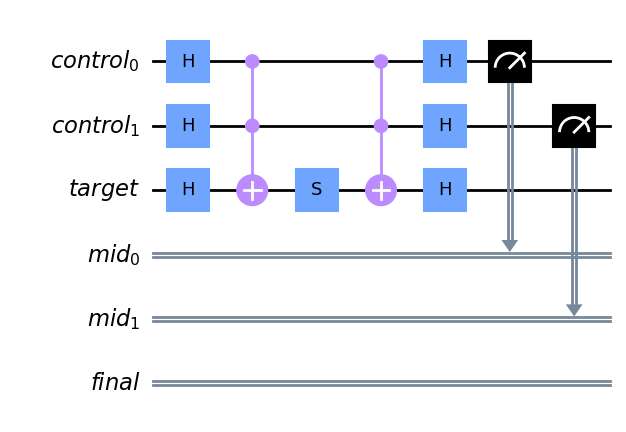

In [11]:
def trial(
    circuit: QuantumCircuit,
    target: QuantumRegister,
    controls: QuantumRegister,
    measures: ClassicalRegister,
):
    """Probabilistically perform Rx(theta) on the target, where cos(theta) = 3/5."""

    
    ## Write your code below this line, making sure it's indented to where this comment begins from ## 
    
    # Hint: You can start solving this problem by coding like this
    # circuit.h([0,1,2])
    circuit.h([0,1,2])
    circuit.ccx(0,1,2)
    circuit.s(2)
    circuit.ccx(0,1,2)
    circuit.h([0,1,2])
    
    circuit.measure([0,1], [0,1])


    ## Do not change the code below this line ##


qc = base.copy_empty_like()
trial(qc, target, controls, mid_measure)
qc.draw("mpl", cregbundle=False)

In [12]:
# Grader Cell: Run this to submit your answer

from qff_ku_grader.challenges.qff_ku2023 import grade_challenge5b

grade_challenge5b(qc)


Congratulations 🎉! Your answer is correct.


### 문제 3

이제 여러분이 해야 할 다음 작업은 측정값을 확인 하는 것입니다. 만약 두 control qubits가 모두 $|0\rangle$로 관측이 되었다면, target qubit에 가해진 gate는 $\cos(\theta) = \frac{3}{5}$을 만족하는 $\theta$에 대해 $R_X(\theta)$ gate가 될 것입니다. 만약 둘 중 하나라도 $|1\rangle$ 이라면, target qubit에 가해지는 gate는 단순한 $X$ gate입니다(왜 이렇게 되는지는 직접 계산해보시면 좋을 것 같습니다!). 따라서, target qubit를 건드리지 않고 두 control qubits만 관측함으로써 target qubit에 알맞은 gate가 가해졌는지 확인할 수 있습니다.

만약 관측 결과를 보았을 때, target qubit에 원하는 gate가 가해지지 않았다고 결론 내릴 수 있는 경우, qubit을 리셋하고 다시 실행하면 됩니다. 실패했을 경우 어떠한 gate가 가해지는지 알 때에는 더 효율적으로 리셋을 할 수 있습니다. 먼저, $|1\rangle$로 관측된 control qubit은 $X$ gate를 가하여 $|0\rangle$로 만들 수 있습니다.

다음 셀에서 `reset_controls` 함수 내부를 채워주시길 바랍니다. `reset_controls`에서는 다음 과정들을 수행하도록 코딩하시면 됩니다.

1. 만약 첫번째 control qubit가 `measure`된 값이 1이라면, (리셋하기 위해)첫번째 control qubit에 $X$ gate를 가합니다.
2. 만약 두번째 control qubit가 `measure`된 값이 1이라면, (리셋하기 위해)두번째 control qubit에 $X$ gate를 가합니다.

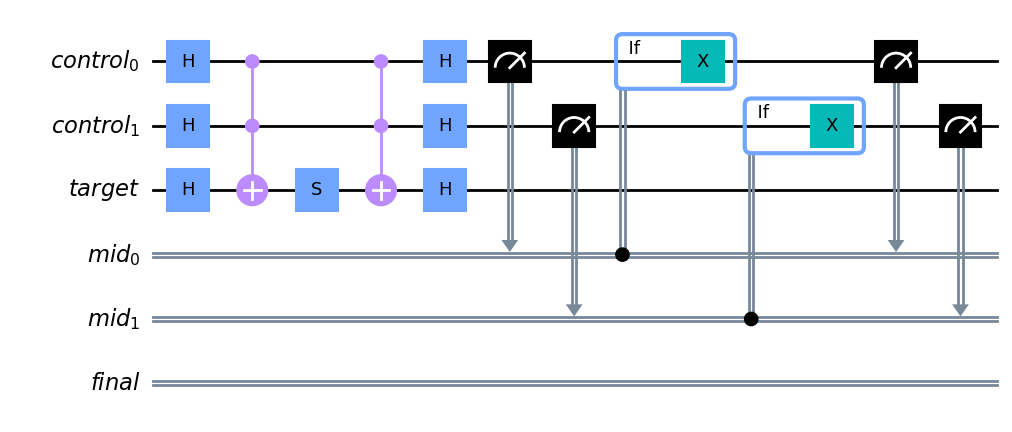

In [13]:
def reset_controls(
    circuit: QuantumCircuit, controls: QuantumRegister, measures: ClassicalRegister
):
    """Reset the control qubits if they are in |1>."""

    
    ## Write your code below this line, making sure it's indented to where this comment begins from ## 

    with circuit.if_test((measures[0],1)):
        circuit.x(0)
    with circuit.if_test((measures[1],1)):
        circuit.x(1)

    ## Do not change the code below this line ##


qc = base.copy_empty_like()
trial(qc, target, controls, mid_measure)
reset_controls(qc, controls, mid_measure)
qc.measure(controls, mid_measure)
qc.draw("mpl", cregbundle=False)

In [14]:
# Grader Cell: Run this to submit your answer

from qff_ku_grader.challenges.qff_ku2023 import grade_challenge5c

grade_challenge5c(qc)


Congratulations 🎉! Your answer is correct.


이제 여러분은 측정 값이 조건에 만족하지 않을 경우 반복하여 회로를 실행시키는 회로를 작성하시면 됩니다. 마지막 문제에서는 Qiskit에서 dynamic circuit 관련하여 현재 지원해주지 않는 기능들을 살펴볼 필요가 있습니다.

첫번째 문제는 Qiskit에서 현재 classical bits에 대해 산술 연산이나 논리 연산을 수행하는 것을 지원하지 않는다는 것입니다. 특히 classical bits가 특정한 값을 갖지 **않는지** 확인하는 것을 지원하지 않습니다. 현재 저희가 만들고자 하는 회로는 양자 회로 중간 측정값이 `00`이 아닌 다른 값일 때 시도를 반복해야 합니다. 이 문제를 해결하기 위해 `if_test()`문을 통해 측정값이 `00`과 같을 경우 **pass** 문을 사용하여 아무것도 수행하지 않도록 할 것이고 **else** 분기를 사용하여 측정값이 `00`이 아닐 때 수행해야할 논리 과정을 수행하도록 할 것입니다.

두번째 문제는 IBM 실제 양자컴퓨터가 dynamical circuit 관련하여 루프를 지원하지 않습니다. 즉, 성공할 때까지 반복 루프를 실행할 수 없다는 것입니다. 단순히 최대 시도 횟수를 고정하고 그 만큼만 시도하는 회로를 만들어 이 문제를 해결할 것입니다.

### 문제 4

아래의 코드 셀에서, `else` 문 내부의 코드를 작성해 주시길 바랍니다. `else`문에는 syndrome 측정이 회로를 다시 실행시켜야 한다는 것을 알려주었을 때, 여러분은 다음과 같은 과정을 거쳐야 합니다.

1. target qubit를 $|0\rangle$로 만들어야 합니다. 문제 3 설명 초반에 말씀드렸다시피 syndrome 측정 상 성공적이지 못했을 경우 target qubit에는 $X$ gate가 가해졌기 때문에 target qubit는 $|1\rangle$ 상태입니다. 이것을 다시 $|0\rangle$ 상태로 만들기 위해서는 어떠한 gate를 가해야 하는지 생각해보시길 바랍니다.

2. `trial` 함수를 불러 다시 회로를 시도해 봅니다.

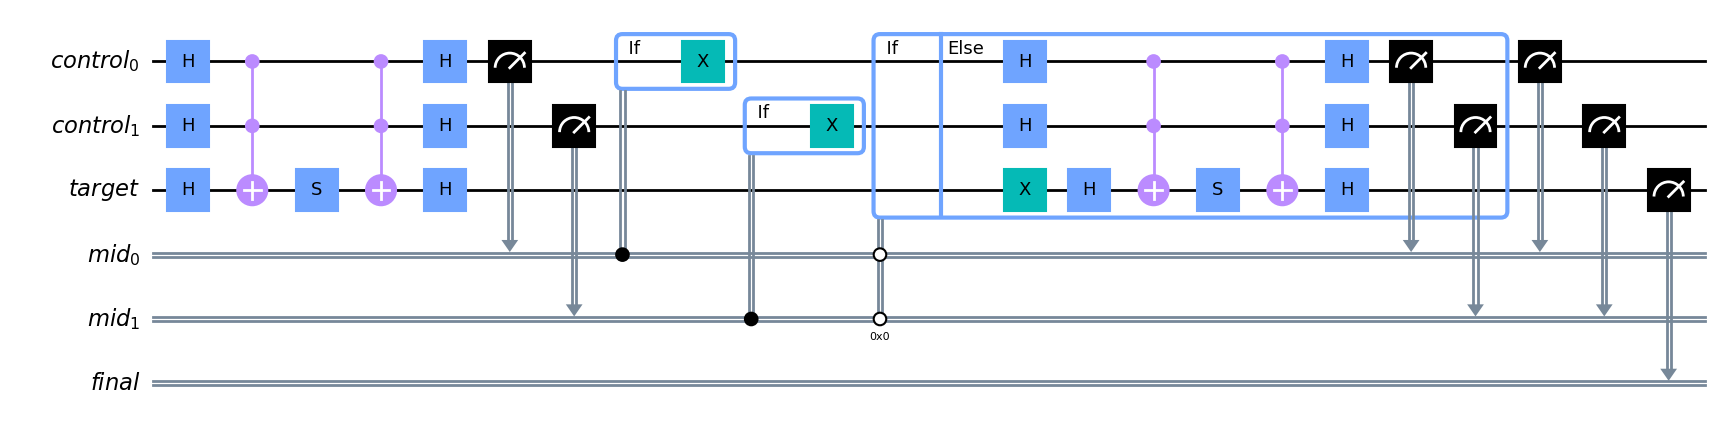

In [20]:
# Set the maximum number of trials
max_trials = 2

# Create a clean circuit with the same structure (bits, registers, etc) as the initial base we set up.
circuit = base.copy_empty_like()

# The first trial does not need to reset its inputs, since the controls are guaranteed to start in the |0> state.
trial(circuit, target, controls, mid_measure)

# Manually add the rest of the trials.  In the future, we will be able to use a dynamic `while` loop to do this, but for now, 
# we statically add each loop iteration with a manual condition check on each one.  
# This involves more classical synchronizations than the while loop, but will suffice for now.

for _ in range(max_trials - 1):
    reset_controls(circuit, controls, mid_measure)
    with circuit.if_test((mid_measure, 0b00)) as else_:
        # This is the success path, but Qiskit can't directly
        # represent a negative condition yet, so we have an
        # empty `true` block in order to use the `else` branch.
        pass
    with else_:
        
        
        ## Write your code below this line, making sure it's indented to where this comment begins from ## 
        circuit.x(target)
        trial(circuit, target, controls, mid_measure)

        
        
        ## Do not change the code below this line ##

    
# We need to measure the control qubits again to ensure we get their final results; this is a hardware limitation.
circuit.measure(controls, mid_measure)

# Finally, let's measure our target, to check that we're getting the rotation we desired.
circuit.measure(target, final_measure)

circuit.draw("mpl", cregbundle=False)

In [21]:
# Grader Cell: Run this to submit your answer

from qff_ku_grader.challenges.qff_ku2023 import grade_challenge5d

grade_challenge5d(circuit)


Congratulations 🎉! Your answer is correct.


회로를 시뮬레이터에서 실행시켜봅시다.

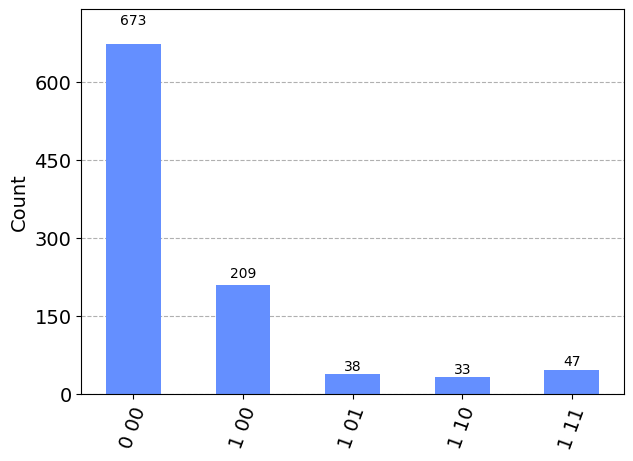

In [17]:
sim = AerSimulator()
job = sim.run(circuit, shots=1000)
result = job.result()
counts = result.get_counts()

plot_histogram(counts)

두 개의 control qubits가 `00`이 관측된 경우 성공적인 결과가 측정되었나요? 다시 한번 강조드리지만, qiskit은 little endian ordering을 사용합니다.

한 번의 시도에서 control qubits 두 개 모두 0 상태로 측정될 확률은 5/8 입니다. 따라서 저희는 총 2번 시도를 했으므로, 뒤에 두 qubits가 `00`으로 관측될 확률은 $\frac{5}{8} + \frac{3}{8}\frac{5}{8} = \frac{55}{64}$ 입니다. 즉 위의 코드 셀에서 그린 히스토그램의 뒤에 두 bit가 00 인 것들이 측정된 횟수의 합은 대략 $1000 \times \frac{55}{64} \simeq 859$ 정도일 것입니다.

control qubits 중 하나라도 1로 측정된 경우에는 target qubits에 가해진 gate는 $X$ gate이므로, 이 경우 target qubits 측정값은 항상 1 이어야 합니다. 이것이 잘 나타났는지도 확인해보세요(히스토그램 막대기 중 뒤의 3개를 보시면 될 것입니다).

$|0\rangle$인 target qubits에 $\cos(\theta) = \frac{3}{5}$을 만족하는 $\theta$에 대해 $R_X(\theta)$ gate를 가하면 0이 측정될 확률은 4/5, 1이 측정될 확률은 1/5입니다. 이것도 잘 나타났는지 확인해보시면 좋을 것 같습니다(히스토그램 막대기 중 앞의 2개를 보시면 될 것입니다).

## 축하합니다!

여러분은 꽤 어려운 난이도의 challenge 문제를 완주하셨습니다! 정말 수고 많으셨습니다.